In [1]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler

import sys,os
sys.path.append('/'.join(os.getcwd().split('/')[:4]))
from config.get import cfg

# import standard packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Data loading

We are going to use the liquid dataset because of the performance of the embedding

> Note: we directly load the encoded features (that used the best AE model found)

In [2]:
use_liquid = True
features_dir = 'liquid' if use_liquid else 'full'

In [3]:
X_train = np.load(cfg["files"][features_dir]["encoded_train_features"])
X_test = np.load(cfg["files"][features_dir]["encoded_test_features"])

# Data Scaling

Since we are loading the encoded features which are coming for one of the inner layers of the AE architecture, there is no guarantie that the data will still be normally scale (as it was the case for the input features). Therefore, we used a standard scaler once again to force the normality of the data.

In [4]:
scaler = StandardScaler()
scaler.fit(X_train)
tX_train = scaler.transform(X_train)
tX_test  = scaler.transform(X_test)

# Cycle clustering analysis

Cycles clustering can be understood as an unsupervised method to classify cycles into a given (`k`) number of categories. The clustering assignments provide a natural way of grouping cycles together. Statistical analysis can be conducted on the clusters to understand the general structural properties of the dataset. 

To this end, we will start by studying the output of a standard clustering algorithm named [K-means](https://en.wikipedia.org/wiki/K-means_clustering).

The starting point of the analysis is to understand which values of ```k``` (the number of clusters) lead to a relevant clustering assignment. ```silhouette``` and ```sse``` plots are the standard way to go.  

In [7]:
# /!\ this cell takes about 10 minutes to run
k_max = 50

silhouettes = []
sse = []
for k in range(2, k_max): # Try multiple k
    print(k,end="\r")
    # Cluster the data and assign the labels
    kmeans =  KMeans(n_clusters=k, random_state=42)
    labels =  kmeans.fit_predict(X_train)
    # Get the Silhouette score
    score = silhouette_score(X_train, labels)
    silhouettes.append({"k": k, "score": score})
    
    sse.append({"k": k, "sse": kmeans.inertia_})
    
# Convert to dataframes
silhouettes = pd.DataFrame(silhouettes)
sse = pd.DataFrame(sse)

In [12]:
def make_evaluation_metric_plot():
    fig = make_subplots(rows=1, cols=2, subplot_titles=("Silhouette method", "SSE method"))

    fig.add_trace(
        go.Scatter(x=silhouettes.k, y=silhouettes.score, ),
        row=1, col=1
    )

    fig.add_trace(
        go.Scatter(x=sse.k, y=sse.sse, ),
        row=1, col=2
    )
    fig.update_xaxes(title_text="k", range=(2, k_max), row=1, col=1)
    fig.update_xaxes(title_text="k", range=(2, k_max), row=1, col=2)

    fig.update_layout(height=500, width=1000, title_text="K-means: evaluation metrics for different values of k", showlegend=False)
    fig.write_html(f"{cfg['fig_dir'][features_dir]['clustering']}kmeans_k_metrics_long.html",full_html=False, include_plotlyjs=False)
    fig.show()

In [13]:
make_evaluation_metric_plot()

Usually, we should observe a maximum spike in the silhouette method plot. This is not the case here. The curve has a clear growing trend but there is no clear reason, at least for our analysis, why we should go above 20 clusters. Hence the silhouette plot is not particularly useful in the task of choosing the best `k`.

However, the elbow method applied on the SSE graph seems to indicate that the steepest slope is in the range $[0, 20]$. For $k > 20$ there is less evidence than, increasing `k` improves the quality of the clustering.

Individual area silhoutte scores are also worth looking at. They can found in the next plot, sorted and grouped by clusters for convinence.

Since the elbow method did not allowed us to exclude any values of `k` before 20, we choose a some values for which there was a spike in the silhouette score (indicating that there was a jump in clustering performance). 

Therefore, we believe that `k=5, 7, 13, 19` may be fair tradeoffs between the goodness of the fit and the number of clusters. In the following plot, we will investigate the quality of the individual cluster to choose our final value.

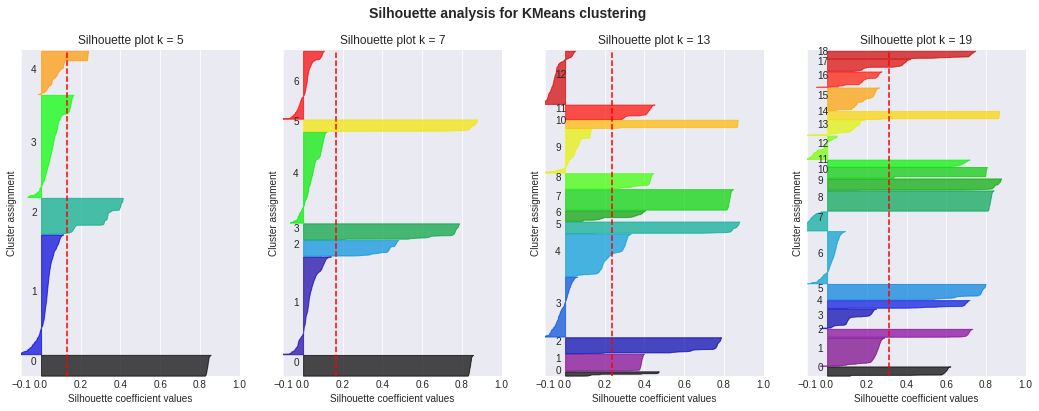

In [60]:
import matplotlib.cm as cm
import matplotlib
matplotlib.style.use('seaborn-darkgrid')
n_clusters_range = [5,7, 13, 19]
fig, axs = plt.subplots(1, len(n_clusters_range))
fig.set_size_inches(18, 6)
for j,k in enumerate(n_clusters_range):
    ax = axs[j]
    ax.set_xlim([-0.1, 1])                         # silhouettes lie within [-0.1, 1] here
    ax.set_ylim([0, len(X_train) + (k + 1) * 10])  # inserting blank space between silhouette
    clusterer = KMeans(n_clusters=k, random_state=10)# Do the clustering 
    labels = clusterer.fit_predict(X_train)
    silhouette_avg = silhouette_score(X_train, labels)             # avg silhouette
    sample_silhouette_values = silhouette_samples(X_train, labels) # scores for each sample
    y_lower = 10
    for i in range(k):
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i] # aggregate per cluster
        ith_cluster_silhouette_values.sort()                                  # sort
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)                                # get color from palette
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("Silhouette plot k = %d" %k)
    ax.set_xlabel("Silhouette coefficient values")
    ax.set_ylabel("Cluster assignment")
    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
plt.suptitle(("Silhouette analysis for KMeans clustering"),
                 fontsize=14, fontweight='bold')

fig.savefig(f"{cfg['fig_dir'][features_dir]['clustering']}silhouette-analysis.png")
plt.show()

**Guidelines to interpret the plot**:

1. Silhouette scores can be interpreted as follows :
    * 1  indicates that the sample is far away from the neighbouring clusters
    * 0  indicates that the sample is on or very close to the decision boundary between two neighbouring clusters
    * <0 indicates that those samples might have been assigned to the wrong cluster. 

2. On the y-axis, the width of clustering is an indicator of the number of data points assigned to the cluster. 
3. The red line indicates an average threshold. Bad clusters are those that fail to reach that target for all data_points assigned to them.

**Key observations from the plot**

1. For `k = 5`:
    * The below avarage ratio is 20% (number of below average / k)
    * Only cluster 1 is below average (red dotted lines) but it is the largest cluster. 
    * The laregest clusters (1 and 3) contain negative silhouette scores
2. For `k = 7`:
    * The below avarage ratio is 43% (number of below average / k)
    * Clusters 0, 2, 3 and 5 are good
    * Clusters 1, 4, 6 and 7 are bad
    * Negative silhouettes scores occur in 43% of the clusterins

3. For `k = 13`:
    * The below avarage ratio is 23% (number of below average / k)


4. For `k = 19`:
    * The below avarage ratio is 42% (number of below average / k)


Only for ```k = 4```, we observe higher variability scores (inside clusters) what indicates that the clustering might not be so good. However, for all ```k```, we do not have any clusters with below-average (red dotted lines) silhouette scores which is a good point.


# Clustering prediction
Now that we chose our final value for `k`, let's train a KMeans model and 

In [61]:
# appears to be the best k value
k = 13
kmeans =  KMeans(n_clusters=k, random_state=42)
train_labels = kmeans.fit_predict(tX_train)
test_labels  = kmeans.predict(tX_test)

In [62]:
fX_train = pd.read_csv(cfg["files"][features_dir]["additional_features_train"]).drop(columns=['Unnamed: 0'])
fX_test  = pd.read_csv(cfg["files"][features_dir]["additional_features_test"]).drop(columns=['Unnamed: 0'])
fX_train

,cycle_id,revenues,costs,token1,token2,token3,profits,profitability
0,1002,1.244307e+16,7.735328e+15,0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2,0xD6F0Bb2A45110f819e908a915237D652Ac7c5AA8,0xa7DE087329BFcda5639247F96140f9DAbe3DeED1,4.707741e+15,True
1,1039,9.525101e+16,1.186148e+16,0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2,0xC0134b5B924c2FCA106eFB33C45446c466FBe03e,0x6B175474E89094C44Da98b954EedeAC495271d0F,8.338954e+16,True
2,1048,1.909315e+17,1.492019e+16,0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2,0x6B175474E89094C44Da98b954EedeAC495271d0F,0xC0134b5B924c2FCA106eFB33C45446c466FBe03e,1.760113e+17,True
3,1049,2.239744e+16,1.519428e+16,0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2,0x6B175474E89094C44Da98b954EedeAC495271d0F,0xb6c4267C4877BB0D6b1685Cfd85b0FBe82F105ec,7.203164e+15,True
4,1052,3.376697e+16,1.358991e+16,0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2,0xD6F0Bb2A45110f819e908a915237D652Ac7c5AA8,0xB4EFd85c19999D84251304bDA99E90B92300Bd93,2.017706e+16,True
...,...,...,...,...,...,...,...,...
4958,47089,1.164057e+17,2.461614e+16,0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2,0x175Ab41E2CEDF3919B2e4426C19851223CF51046,0x6B3595068778DD592e39A122f4f5a5cF09C90fE2,9.178961e+16,True
4959,47092,4.824665e+16,2.912150e+16,0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2,0x73374Ea518De7adDD4c2B624C0e8B113955ee041,0xdAC17F958D2ee523a2206206994597C13D831ec7,1.912516e+16,True
4960,47094,7.319634e+16,2.365014e+16,0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2,0x6B3595068778DD592e39A122f4f5a5cF09C90fE2,0x175Ab41E2CEDF3919B2e4426C19851223CF51046,4.954621e+16,True
4961,47097,1.916508e+16,4.316117e+16,0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2,0x57Ab1ec28D129707052df4dF418D58a2D46d5f51,0x68A118Ef45063051Eac49c7e647CE5Ace48a68a5,-2.399609e+16,False


In [63]:
fX_train['cluster'] = train_labels
fX_train.cluster = fX_train.cluster.apply(str) # make plot look nicer
fX_test['cluster'] = test_labels
fX_test.cluster = fX_test.cluster.apply(str) # make plot look nicer

## Clustering validation


In [64]:
#simple_ordering of clusters (lengend will be easier to read)
cluster_order = {"cluster": [str(i) for i in range(k)]}

In [65]:
def bar_char_cluster(data, col, title, callback = lambda fig: 0, train=True):
    set_name = ('train' if train else 'test')
    fig = px.bar(
        data.reset_index(), 
        x='cluster', y=col, color='cluster',
        title=f"{title} ({set_name} set)",
        category_orders=cluster_order,
    )
    fig.update_xaxes(type='category')
    callback(fig)
    fig.write_html(f"{cfg['fig_dir'][features_dir]['clustering']}{title.replace(' ', '_')}_{set_name}_small.html", full_html=False, include_plotlyjs=False)
    fig.show()

In [66]:

def nb_cycles_clusters(grouper, **kwargs):
    bar_char_cluster(grouper.count(),
        'cycle_id',"Number of cycles per cluster",**kwargs)
    
def profits_clusters(grouper, **kwargs):
    bar_char_cluster(grouper.median(),
        'profits',"Profit per cluster", **kwargs)
    
def profitability_clusters(grouper, **kwargs):
    bar_char_cluster(grouper.mean(),
        'profitability',"Profitability of each cluster",
         lambda fig: fig.update_yaxes(range=(0.9, 1)), **kwargs)

def median_token_clusters(grouper, **kwargs):
    def weighted_avg(g):
        return pd.concat([g.token1, g.token2, g.token3]).value_counts().median()
    
    bar_char_cluster(grouper.apply(weighted_avg),
        0,"Median of token distribution within each cluster", **kwargs)
                     
from scipy.stats import entropy

def entropy_clusters(grouper, **kwargs):
    def weighted_avg(g):
        return entropy(pd.concat([g.token1, g.token2, g.token3]).value_counts())
        
    bar_char_cluster(grouper.apply(weighted_avg),
        0,"Entropy of token distribution within each cluster", **kwargs)

In [67]:
pipeline_metrics= [
    nb_cycles_clusters,
    profits_clusters,
    profitability_clusters,
    median_token_clusters,
    entropy_clusters
]

train_grouper = cluster_profits = fX_train.groupby('cluster')

[agg(train_grouper) for agg in pipeline_metrics]

[None, None, None, None, None]

In [69]:
def token_df(X):
    def select(i):
        df = X[[f"token{i}",'cluster']]
        df = df.rename(columns = {f"token{i}":'token'})
        #df.token = df.token.str[:20]
        return df
    return pd.concat([select(1), select(2), select(3)],axis=0)

def token_distribution(df):
    fig = px.histogram(
        df, x="token", 
        facet_col="cluster",  facet_col_wrap=4, 
        log_y=True, 
        category_orders=cluster_order,
        color='cluster'
    )
    #fig.update_xaxes(matches=None)
    fig.update_xaxes(showticklabels=False, visible=True)
    fig.update_layout(title='Token distribution per cluster')
    #fig.update_traces(showlegend=True)
    fig.show()
    
tdf = token_df(fX_train) 
token_distribution(tdf)

## Validation on test set

In [70]:
test_grouper = fX_test.groupby('cluster')
[agg(test_grouper, train=False) for agg in pipeline_metrics]

[None, None, None, None, None]

In [71]:
    
test_tdf = token_df(fX_test) 
token_distribution(test_tdf)